# Differential Equations via Finite Differences

We now see our first application: solving differential equations.
We will focus on the following differential equations:

1. Indefinite integration:
$$
\begin{align*}
u(0) &= c, \\
u' &= f(x)
\end{align*}
$$
2. Linear time-evolution problems:
$$
\begin{align*}
u(0) &= c, \\
u' - a(x) u &= f(x)
\end{align*}
$$
2. Two-point boundary value problems:
$$
\begin{align*}
u(0) &= c_0, \\
u(1) &= c_1, \\
u'' - a(x) u &= f(x)
\end{align*}
$$
4. Nonlinear time-evolution problems:
$$
\begin{align*}
u(0) &= u_0, \\
u' &= f(u(x))
\end{align*}
$$

Our approach to solving these is to
1. Approximate the solution evaluated on a grid $(n+1)$-point grid
$x_k = kh$ for $h = 1/n$ and $k=0,…,n$ for a vector $𝐮_n ∈ ℝ^{n+1}$
that will be determined by solving a linear system:
$$
\begin{bmatrix}
u(x_0) \\
⋮ \\
u(x_n)
\end{bmatrix} ≈ \underbrace{\begin{bmatrix}
u_0 \\
⋮ \\
u_n
\end{bmatrix}}_{𝐮_n}
$$
2. Replace the derivatives with the finite-difference approximation
$$
\begin{align*}
u'(x_k) ≈ {u(x_{k+1}) - u(x_k) \over h} ≈ {u_{k+1} - u_k \over h} \qquad\hbox{(Forward-difference)} \\
u'(x_k) ≈ {u(x_k) - u(x_{k-1}) \over h} ≈ {u_k - u_{k-1} \over h} \qquad\hbox{(Backward-difference)} \\
u''(x_k) ≈ {u(x_{k+1}) - 2u(x_k) + u_{k-1} \over h^2} ≈ {u_{k+1} - u_k \over h}
\end{align*}
$$
3. Recast the differential equation as a linear system whose solution
is $𝐮_n$, which we solve using numerical linear algebra.
Add the initial/boundary conditions as extra rows to make sure the
system is square.


# 1. Linear time-evolution problems


## Indefinite integration

We begin with the simplest differential equation:
$$
\begin{align*}
u(0) &= c \\
u'(x) &= f(x)
\end{align*}
$$
Using the forward-difference (which is the standard finite-difference) approximation we get,
if $u_k ≈ u(x_k)$, for $k = 0, …, n-1$:
$$
u'(x_k) ≈ {u_{k+1} - u_k \over h} = f(x_k)
$$
We do not include $k = n$ to avoid going outside our grid.
Thus we have the rectangular system:
$$
\underbrace{{1 \over h} \begin{bmatrix}
-1 & 1\\
& \ddots & \ddots \\
&& -1 & 1
\end{bmatrix}}_{D_n} 𝐮_n = \underbrace{\begin{bmatrix} f(x_0) \\ \vdots \\ f(x_{n-1})
\end{bmatrix}}_{𝐟^{\rm L}}
$$
where the super-script $L$ denotes that we are evaluating on the left.
Here $D_n ∈ ℝ^{n,n+1}$ so this system is not-invertible. Thus we need to
add an extra row, coming from the initial condition: $𝐞_1^⊤ 𝐮_n = c$,
that is:
$$
\begin{bmatrix}
𝐞_1^⊤ \\
D_n
\end{bmatrix} 𝐮_n = \underbrace{ \begin{bmatrix}
1 \\
-1/h & 1/h\\
& \ddots & \ddots \\
&& -1/h & 1/h
\end{bmatrix}}_L 𝐮_n = \begin{bmatrix} c \\ 𝐟^{\rm L} \end{bmatrix}
$$
(With our grid $1/h = n$ but we leave it as-is since on a different
interval $[a,b]$ this relationship would be $h = (b-a)/n$.)
This is a lower-triangular bidiagonal system, so can be solved using
forward substitution in $O(n)$ operations.

Let's do an example of integrating $\cos x$, and see if our method matches
the true answer of $\sin x$. First we construct the system
as a lower-triangular, `Bidiagonal` matrix:

In [1]:
using LinearAlgebra, Plots

n = 20
x = range(0, 1; length=n+1)
h = 1/n
A = Bidiagonal([1; fill(1/h, n)], fill(-1/h, n), :L)

21×21 Bidiagonal{Float64, Vector{Float64}}:
   1.0     ⋅      ⋅      ⋅      ⋅   …     ⋅      ⋅      ⋅      ⋅     ⋅ 
 -20.0   20.0     ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅   -20.0   20.0     ⋅      ⋅         ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅   -20.0   20.0     ⋅         ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅   -20.0   20.0        ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅   -20.0  …     ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅   …     ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅ 

We can now solve for our particular problem:

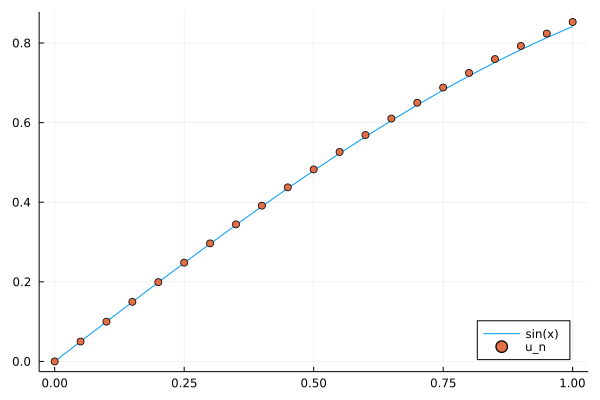

In [2]:
c = 0 # u(0) = 0
f = x -> cos(x)

𝐟 = f.(x[1:end-1]) # evaluate f at all but last points
uₙ = A \ [c; 𝐟]

plot(x, sin.(x); label="sin(x)", legend=:bottomright)
scatter!(x, uₙ; label="u_n")

Pretty good! We can estimate how fast it converges:

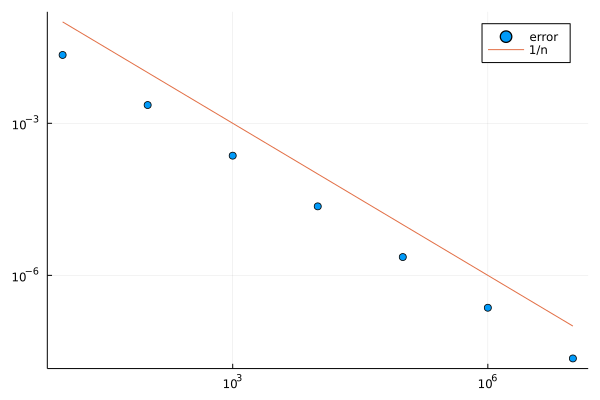

In [3]:
# Error from indefinite integration with c and f
function indef_err(u, c, f, n)
    x = range(0, 1; length=n+1)
    h = 1/n
    L = Bidiagonal([1; fill(1/h, n)], fill(-1/h, n), :L)

    𝐟 = f.(x[1:end-1]) # evaluate f at all but last points
    uₙ = L \ [c; 𝐟]
    norm(uₙ - u.(x), Inf)
end

ns = 10 .^ (1:7) # solve up to n = 10 million
scatter(ns, indef_err.(sin, 0, f, ns); xscale=:log10, yscale=:log10, label="error")
plot!(ns, ns .^ (-1); xscale=:log10, yscale=:log10, label="1/n")

## Forward Euler

Now consider
$$
\begin{align*}
u(0) &= c \\
u'(x) - a(x) u(x) &= f(x)
\end{align*}
$$
Again we can replace the discretisation using finite-differences, giving us
$$
{u_{k+1} - u_k \over h} - a(x_k) u_k = f(u_k)
$$
for $k = 0,…,n-1$. We need to add the term $a(x_k) u_k$ to our differential equation,
that is. We do this using the $n × n+1$ _(left) restriction matrix_ that takes a vector
evaluated at $x_0,…,x_n$ and restricts it to $x_0,…,x_{n-1}$,
$$
S_n^{\rm L} = \begin{bmatrix} 1 \\ &⋱ \\ &&1 & 0 \end{bmatrix}
$$
as well as the $n+1 × n+1$ _multiplication matrix_
$$
A_n = \begin{bmatrix} a(x_0) \\ &⋱\\&& a(x_n) \end{bmatrix}
$$
Putting everything together we have the system:
$$
\begin{bmatrix}
𝐞_1^⊤ \\
D_n -  S_n^{\rm L}  A_n
\end{bmatrix} 𝐮_n = \underbrace{ \begin{bmatrix}
1 \\
a(x_0)-1/h & 1/h\\
& \ddots & \ddots \\
&& a(x_{n-1})-1/h & 1/h
\end{bmatrix}}_L 𝐮_n = \begin{bmatrix} c \\ 𝐟^{\rm L} \end{bmatrix}
$$


**Remark** Note this can be reduced to an integral
$$
u(t) = c \E^{a t} + \E^{a x} \int_0^x f(t) \E^{-a t} \hbox d t
$$
and solved as above but this approach is harder to generalise.


## Backward Euler

a = 1
c =